In [3]:
import torch
import os
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import json
import imageio
# from google.colab import drive
# drive.mount('/content/drive')
# Make sure to switch runtime to the GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
print(device)


Running on the GPU
cuda:0


In [2]:
# Write a class to read in the image frame and store all the data related to it
class FrameManager:
    def __init__(self):
        self.test_frames = []
        self.train_frames = []
        self.val_frames = []
        self.cam_angle = 0
        self.f = None
        self.H = None
        self.W = None

    def prepare_test_data(self):
      rays_o, rays_d = None, None
      for frame in self.test_frames:
        f_rays_o, f_rays_d = frame.get_rays(device)
        if rays_o is None:
          rays_o, rays_d = f_rays_o, f_rays_d
        else:
          rays_o = torch.vstack((rays_o, f_rays_o))
          rays_d = torch.vstack((rays_d, f_rays_d))
      return rays_o, rays_d

    def prepare_train_data(self):
      rays_o, rays_d = None, None
      for frame in self.train_frames:
        f_rays_o, f_rays_d = frame.get_rays(device)
        if rays_o is None:
          rays_o, rays_d = f_rays_o, f_rays_d
        else:
          rays_o = torch.vstack((rays_o, f_rays_o))
          rays_d = torch.vstack((rays_d, f_rays_d))
      return rays_o, rays_d

    def prepare_val_data(self):
      rays_o, rays_d = None, None
      for frame in self.val_frames:
        f_rays_o, f_rays_d = frame.get_rays(device)
        if rays_o is None:
          rays_o, rays_d = f_rays_o, f_rays_d
        else:
          rays_o = torch.vstack((rays_o, f_rays_o))
          rays_d = torch.vstack((rays_d, f_rays_d))
      return rays_o, rays_d


    def read_frames(self, path):
        cfgs = ['transforms_test.json', 'transforms_train.json', 'transforms_val.json']
        data_cfg = {}
        for i, cfg in enumerate(cfgs):
            with open(os.path.join(path, cfg)) as json_file:
                data_cfg[i] = json.load(json_file)

        for i in range(3):
            data = data_cfg[i]
            frms = []
            for frame in data["frames"]:
                img_file = os.path.join(path, frame['file_path'] + '.png')
                self.cam_angle = data_cfg[0]['camera_angle_x']
                img = imageio.imread(img_file)
                self.H, self.W = img.shape[0], img.shape[1]
                '''It's basic geometry: you have a right angle triangle, with half the FOV as one of the angles (a), and half your image size as the opposite side (A). To calculate the focal length F, use tan(a) = A/F,
which gives F = A/tan(a)'''
                self.f = (0.5 * self.W)/(np.tan(0.5 * self.cam_angle))
                new_frame = Frame(img, np.array(frame['transform_matrix']), self.f)
                frms.append(new_frame)
            if i == 0:
                self.test_frames = frms
            elif i == 1:
                self.train_frames = frms
            else:
                self.val_frames = frms


class Frame:
    def __init__(self, image, pose, f):
        self.img = image
        self.pose = pose
        self.H, self.W = image.shape[0], image.shape[1]
        self.f = f
        self.samples = None
        self.rays_o = None
        self.rays_d = None
        self.depth_values = None

    def copy_to_device(self, device):
        self.img = torch.from_numpy(self.img).to(device)
        self.pose = torch.from_numpy(self.pose).to(device)

    def make_tensors(self):
      self.img = torch.from_numpy(self.img)
      self.pose = torch.from_numpy(self.pose)

    # function to get the rays from the image through every pixel of the Camera (Using Pytorch) on GPU
    # Assuming a pinhole camera model
    def get_rays(self, device):
        # self.copy_to_device(device)
        self.make_tensors()
        # i, j = torch.meshgrid(torch.arange(self.H).to(device), torch.arange(self.W).to(device), indexing='ij')
        i, j = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing='ij')
        i, j = i.transpose(1, 0), j.transpose(1, 0)
        dirs = torch.stack([(i-self.W*0.5)/self.f, -(j-self.H*0.5)/self.f, -torch.ones_like(i)], -1)

        rays_d = torch.sum(dirs[..., None, :] * self.pose[:3, :3], -1)
        rays_o = torch.broadcast_to(self.pose[:3, -1], rays_d.shape)
        self.rays_o = rays_o
        self.rays_d = rays_d

        return rays_o, rays_d






In [3]:
# takes a list of frames and samples all the rays for the frames uniformly and returns the rays and the depth values
# could make it a method of the FrameManager class
def sample_frame(frames, num_samples, near, far, dev = 'cuda:0'):

    sample_space = torch.linspace(0., 1., num_samples, device=dev)
    depth = near*(1.-sample_space) + far*sample_space
    mid_depth = (depth[1:] + depth[:-1])/2
    rand_sampling = torch.rand([num_samples], device=dev)
    upper_sample = torch.cat([mid_depth, depth[-1:]], dim=-1)
    lower_sample = torch.cat([depth[:1], mid_depth], dim=-1)
    depth_value = lower_sample + rand_sampling * (upper_sample - lower_sample)
    depth_value = depth_value.expand(list(frames.rays_o.shape[:-1]) +[num_samples])
    #pts are the points on the ray in the format (width, height, n_samples, 3)
    pts = frames.rays_o[..., None, :] + frames.rays_d[..., None, :] * depth_value[..., None]
    frames.samples = pts
    frames.depth_values = depth_value
    return pts, depth_value





In [4]:
class Model(nn.Module):

    def __init__(self):

        super().__init__()

        self.input_layer = nn.Linear(60, 256, dtype=torch.float64)
        self.hidden_layer_block_1 = nn.ModuleList([nn.Linear(256, 256, dtype=torch.float64) for i in range(4)])
        self.skip_connection_layer = nn.Linear(316,256, dtype=torch.float64)
        self.hidden_layer_block_2 = nn.ModuleList([nn.Linear(256, 256, dtype=torch.float64) for i in range(2)])
        self.density_output_layer = nn.Linear(256, 257, dtype=torch.float64)
        self.last_layer = nn.Linear(280, 128, dtype=torch.float64)
        self.rgb_output = nn.Linear(128, 3, dtype=torch.float64)


    def forward(self, position, direction):

        # print(position.size())
        # print(direction.size())

        encoded_position, encoded_direction = self.positional_encoding(position, direction) # should return shape of (# of samples, 60) and (# of samples, 24)

        # print(encoded_position.dtype)
        # print(encoded_direction.dtype)
        # print(encoded_position.size())
        # print(encoded_direction.size())

        input_feature_origin = encoded_position.clone().to(device)
        x = torch.relu(self.input_layer(encoded_position))
        for layer in self.hidden_layer_block_1:
            x = torch.relu(layer(x))
        skip_connection = torch.cat((input_feature_origin, x), dim=1)
        x = torch.relu(self.skip_connection_layer(skip_connection))
        for layer in self.hidden_layer_block_2:
            x = torch.relu(layer(x))
        print(x.dtype)
        x = torch.relu(self.density_output_layer(x))
        print(x.dtype)
        density = x[:,-1]
        direction_connection = torch.cat((encoded_direction, x[:,:-1]), dim=1)
        # print(direction_connection.size())
        x = torch.relu(self.last_layer(direction_connection))
        print(x.dtype)
        color = torch.sigmoid(self.rgb_output(x))

        return color, density

    def positional_encoding(self, position, direction, L_P = 10, L_D =4):

        encoded_position = []
        encoded_direction = []

        for i in range (L_P):
            encoded_position.append(torch.sin(2**i * np.pi * position))
            encoded_position.append(torch.cos(2**i * np.pi * position))

        for i in range (L_D):
            encoded_direction.append(torch.sin(2**i * np.pi * direction))
            encoded_direction.append(torch.cos(2**i * np.pi * direction))

        # print(torch.cat(encoded_position, dim=1).size())
        # print(encoded_direction)


        return torch.cat(encoded_position, dim=1), torch.cat(encoded_direction, dim=1)










In [21]:


# assuming that points is a list of size (num_of_rays, num_of_samples, 6) so 3 points for position, 3 for direction for every sample on a ray
# render_rays will query the network at each sample point to determine the color and density and that point. We then use volume rendering to determine the final color.
# dt is distance between adjacent samples; prob just near-far / num of samples for uniform sampling
def render_rays(model, frame):

    # dt = torch.ones(points.size()[0])/points.size()[0] # just for testing
    dt = frame.depth_values[..., 1:] - frame.depth_values[..., :-1]
    dt = torch.cat([dt, 1e20*torch.ones_like(dt[..., :1])], dim = -1).to(device) #torch.Size([800, 800, 8])
    # print(dt.shape)
    positions = frame.samples #torch.Size([800, 800, 8, 3]) (img size x, img size y, num_samples, 3)
    directions = frame.rays_d #torch.Size([800, 800, 3]) (img size x, img size y, 3)
    directions = directions.unsqueeze(2).expand(positions.shape).to(device) #torch.Size([800, 800, 8, 3])

    positions_reshaped = torch.reshape(positions,(-1,3)).to(device)
    directions_reshaped = torch.reshape(directions, (-1,3)).to(device)
    color, density = model(positions_reshaped, directions_reshaped) # color should be (# of samples * # of rays, 3) density should be (# of samples * # of rays, 1)
    # print(positions_reshaped.dtype)
    color = torch.reshape(color, positions.shape).to(device)

    density = torch.reshape(density, (positions.shape[0], positions.shape[1], positions.shape[2])).to(device)

    # print(color.shape)
    # print(density.shape)

    alpha = 1 - torch.exp(-density*dt)
    transmittance = torch.cumprod(torch.exp(-density * dt), dim=2)
    # print(transmittance.shape)
    # print(alpha.shape)
    # print(color.shape)
    rgb = torch.sum(alpha[:,:,:,None] * transmittance[:,:,:,None] * color, dim=2)
  
    return rgb


def train(model, epochs, data, learning_rate = 5e-4):

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    run = np.linspace(0, epochs-1, epochs)
    losses = np.zeros()


    for i in range(epochs):
      print("Epoch number", i)
      index = np.random.randint(len(data.train_frames)) #randomize input image per epoch
      fr = data.train_frames[index]
      fr.get_rays(device)
      sample_frame(fr, 8, 1, 10, dev = 'cuda:0')
      predicted = render_rays(model, fr)
      loss = torch.sum((predicted-fr.img)**2)
      print("Loss:", loss)
      # print(loss.shape)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   test_frame = data.test_frames[0]
    #   test_frame.get_rays(device)
    #   sample_frame(fr, 8, 1, 10, dev = 'cpu')
    #   predicted = render_rays(model, fr)



# model = Model()

# one = torch.zeros(10, 3)
# two = torch.zeros(10, 3)
# # output = model(one, two)
# # print(output)
# points = torch.rand(50,25,6) # 50 rays, 25 samples per ray, 6
# output = render_rays(model, points, 0.1)

# data = torch.cat((rays, actual), dim=3)
# train(model, 10, (rays,actual), 0.05, .01)

In [22]:
frameManager = FrameManager()
!ls drive/MyDrive/EECS\ 504\ Final\ Project/NOVEL_NERF/Data/

model = Model()
model.to(device)
frameManager.read_frames('drive/MyDrive/EECS 504 Final Project/NOVEL_NERF/Data/lego')
train(model, 5, frameManager)


/var/folders/66/l_w8kbw95zzctrjl53kjsgq00000gn/T/ipykernel_54841/4024155111.py:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_file)


Epoch number 0


KeyboardInterrupt: 

torch.Size([800, 800, 3]) torch.Size([800, 800, 3])


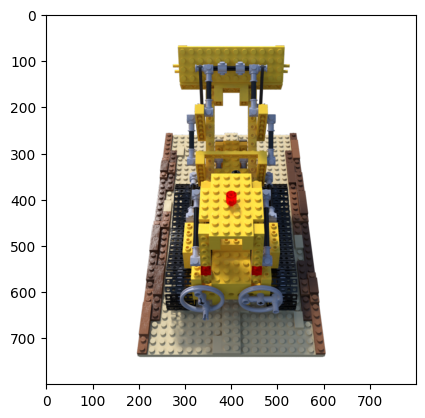

In [7]:
import matplotlib.pyplot as plt
plt.imshow(frameManager.test_frames[0].img)
test_rays, test_directions = frameManager.test_frames[0].get_rays(device)
print(test_rays.shape, test_directions.shape)


In [10]:
# print(test_rays)
# print(test_directions)
smpl_points, depths = sample_frame(frameManager.test_frames[0], 8, 1, 10, dev = 'cuda:0')
print(smpl_points.shape, depths.shape)
dt = frameManager.test_frames[0].depth_values #[img size x, img size y, num_samples]
dt = frameManager.test_frames[0].depth_values[..., 1:] - frameManager.test_frames[0].depth_values[..., :-1]
dt = torch.cat([dt, 1e20*torch.ones_like(dt[..., :1])], dim = -1)
positions = frameManager.test_frames[0].samples
directions = frameManager.test_frames[0].rays_d
print(dt.shape)



torch.Size([800, 800, 8, 3]) torch.Size([800, 800, 8])
torch.Size([800, 800, 8])


In [ ]:
### only to test the model with random input
import torch
from torch.utils.data import Dataset, DataLoader

class NeRFDataset(Dataset):
    def __init__(self, rays, target_images):
        self.rays = rays
        self.target_images = target_images

    def __len__(self):
        return len(self.rays)

    def __getitem__(self, index):
        return self.rays[index], self.target_images[index]

rays = torch.randn(50,25,6)
actual = torch.randn(50,3)

nerf_dataset = NeRFDataset(rays, actual)
batch_size = 32
train_data_loader = DataLoader(nerf_dataset, batch_size=batch_size, shuffle=True)
train(model, 10, train_data_loader, 0.05, 0.01)

In [20]:
density = torch.rand(800,800,8)
dt = torch.rand(800,800,8)
color = torch.rand(800,800,8,3)
alpha = 1 - torch.exp(-density*dt)
transmittance = torch.cumprod(torch.exp(-density * dt), dim=2)
# print(transmittance.shape)
# print(alpha.shape)
# print(color.shape)
print(alpha[:,:,None,:].shape)
rgb = torch.sum(alpha[:,:,:,None] * transmittance[:,:,:,None] * color, dim=2)
print(rgb.shape)

torch.Size([800, 800, 1, 8])
torch.Size([800, 800, 3])
